# **Food Hazard Detection Challenge with CatBoost**

## **Introduction**

This notebook is part of the **Food Hazard Detection Challenge (SemEval 2025 Task 9)**, which focuses on developing machine learning models to classify food hazards from incident reports. The challenge consists of two subtasks:

1. **Hazard and Product Category Prediction (Subtask 1)**: Classifying food incidents into broader categories of hazards (e.g., allergens, contaminants) and products (e.g., dairy, bakery).
2. **Hazard and Product Vector Prediction (Subtask 2)**: Identifying the exact hazard (e.g., "Salmonella") and product (e.g., "Ice Cream") using multi-label classification.

### **Project Goals**
The primary goals of this notebook are:
1. **Build a Robust Classifier:** Utilize CatBoost, an efficient and lightweight gradient boosting framework, to classify food hazards effectively.
2. **Handle Imbalanced Data:** Address the challenges of class imbalance inherent in the dataset by leveraging CatBoost's built-in support for class weighting.
3. **Optimize Performance:** Use hyperparameter tuning to find the best model configuration while maintaining computational efficiency.
4. **Evaluate Results:** Compare the model’s performance using the **Macro F1 Score**, which ensures equal importance for all classes, regardless of size.

### **Why CatBoost?**
CatBoost was chosen as the advanced model for this task because:
- It is computationally efficient and performs well even on smaller datasets.
- It handles categorical and numerical features seamlessly, making it ideal for the structured and sparse textual data in this challenge.
- Built-in class weighting helps mitigate the effects of imbalanced datasets.
- It provides robust performance without requiring extensive hyperparameter tuning, making it suitable for a laptop-friendly setup.

### **Dataset Overview**
The dataset comprises incident reports, including short texts (titles) and long texts (text), with corresponding labels:
- **Hazard Category:** Broad categories of food hazards.
- **Product Category:** Broad categories of food products.
- **Hazard Vector:** Specific hazards such as "Salmonella."
- **Product Vector:** Specific food products like "Ice Cream."

In this notebook, we focus on predicting the **Hazard Category - Product Category** and **Hazard vector - Product vector** using **CatBoost**. The workflow includes:
- Preprocessing text data using **TF-IDF vectorization**.
- Splitting the dataset into training and test subsets.
- Training and tuning the CatBoost model.
- Evaluating performance with the **Macro F1 Score** and **classification reports**.
- Make predictions on the validation dataset and saving them for later


---

**Load Libraries**

---

In [ ]:
# Load required libraries
import pandas as pd # Pandas: For data loading and manipulation

# Scikit-learn: For TF-IDF, model building, and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from IPython.display import display # Display the TF-IDF DataFrames
# Import required libraries
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import ListedColormap
# Setting seed for reproducibility
np.random.seed(42)


ModuleNotFoundError: No module named 'catboost'

---

**Load Datasets**

---

#### Loading the Dataset

We begin by loading the dataset, which includes incident reports related to food hazards. The dataset has several features, such as year, month, day, country, title, and full text. Each incident has corresponding labels such as `product-category` and `hazard-category`.


In [14]:
train_data = pd.read_csv('C:\\Users\\magda\\Desktop\\cleaned_data\\cleaned_train_data.csv')
validation_data = pd.read_csv('C:\\Users\\magda\\Desktop\\cleaned_data\\cleaned_validation_data.csv')

---

**TF-IDF Vectorization**

---

#### Preprocessing 

**TF-IDF Vectorization:**
To transform textual data into numerical features suitable for machine learning, we use TF-IDF vectorization. We will apply this separately to `titles` and `text`.


In [15]:
# Extract text and title data from train_data
text_data_tfidf = train_data['text']
title_data_tfidf = train_data['title']

# Extract text and title data from validation_data
val_text_data_tfidf = validation_data['text']
val_title_data_tfidf = validation_data['title']

# Initialize separate TF-IDF vectorizers for text and titles from train_data
text_vectorizer = TfidfVectorizer(max_features=50)  # Top 50 features for text
title_vectorizer = TfidfVectorizer(max_features=50)  # Top 50 features for titles

# Initialize separate TF-IDF vectorizers for text and titles from validation_data
val_text_vectorizer = TfidfVectorizer(max_features=50)  # Top 50 features for text
val_title_vectorizer = TfidfVectorizer(max_features=50)  # Top 50 features for titles


# Fit and transform the text and title data for train_data
text_tfidf_matrix = text_vectorizer.fit_transform(text_data_tfidf)
title_tfidf_matrix = title_vectorizer.fit_transform(title_data_tfidf)

# Fit and transform the text and title data for validation_data
val_text_tfidf_matrix = text_vectorizer.fit_transform(val_text_data_tfidf)
val_title_tfidf_matrix = title_vectorizer.fit_transform(val_title_data_tfidf)

# Convert the matrices to DataFrames for better readability for train_data
text_tfidf_df = pd.DataFrame(text_tfidf_matrix.toarray(), columns=text_vectorizer.get_feature_names_out())
title_tfidf_df = pd.DataFrame(title_tfidf_matrix.toarray(), columns=title_vectorizer.get_feature_names_out())

# Convert the matrices to DataFrames for better readability for validation_data
val_text_tfidf_df = pd.DataFrame(text_tfidf_matrix.toarray(), columns=text_vectorizer.get_feature_names_out())
val_title_tfidf_df = pd.DataFrame(title_tfidf_matrix.toarray(), columns=title_vectorizer.get_feature_names_out())

**Interpreting TF-IDF Values**

(In this analysis, we visualize the TF-IDF scores of terms from the text and title datasets. These values help identify the most significant terms in our dataset.)\

- **Top 20 TF-IDF Features (Title)**
This chart shows the most significant terms in the title field based on their TF-IDF scores. High-ranking terms like "recall," "due," and "undeclared" suggest a focus on product recall announcements and allergen-related issues. These terms are distinct to specific titles.

- **Top 20 TF-IDF Features (Text)**
This chart highlights key terms from the text field. Prominent terms like "product," "recall," and "food" indicate a strong emphasis on product recall notifications and food safety. Additional terms like "consumer," "milk," and "allergy" reinforce the dataset’s relevance to consumer alerts and allergen concerns.



C:\Users\magda\AppData\Local\Temp\ipykernel_6864\294503889.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))


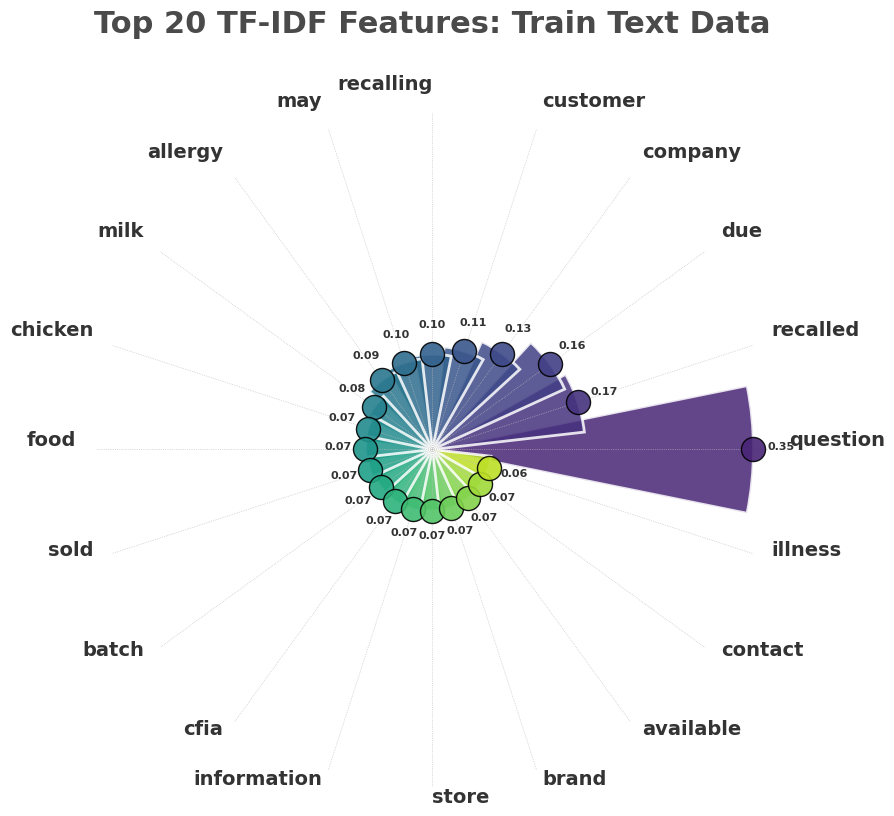

In [82]:
import matplotlib.pyplot as plt
import numpy as np

def create_sunburst_with_adjusted_labels(tfidf_df, title, colormap):
    # Calculate mean TF-IDF scores
    top_features = tfidf_df.mean().nlargest(20)  # Top 20 features based on mean values

    # Prepare data for sunburst plot
    features = top_features.index
    values = top_features.values
    colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    ax.set_facecolor("#ffffff")
    
    # Compute angle for each feature
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    values = np.concatenate((values, [values[0]]))

    # Add concentric segments (sunburst)
    for idx, (angle, value, color) in enumerate(zip(angles[:-1], values[:-1], colors)):
        ax.bar(x=angle, height=value, width=0.4, bottom=0, color=color, edgecolor='white', linewidth=2, alpha=0.85)
        
        # Draw a small circle for highlight effect at the top of each bar
        ax.scatter(angle, value, s=300, color=color, edgecolor='black', zorder=3, alpha=0.9)
        
        # Adjust label position to be closer to the bars dynamically
        label_position = value + 0.03  # Adjusting position for label to be closer
        ax.text(angle, label_position, f'{value:.2f}', ha='center', fontsize=8, fontweight='bold', color='#333333', zorder=4)

    # Set the labels for each feature
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=14, fontweight='bold', ha='center', color='#333333', rotation=45, va='bottom')
    
    # Move the labels dynamically based on angle for better alignment
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        label.set_rotation_mode('anchor')
        if 0 <= angle < np.pi / 2 or 3 * np.pi / 2 <= angle < 2 * np.pi:  # Right-side labels
            label.set_horizontalalignment('left')
        else:  # Left-side labels
            label.set_horizontalalignment('right')

    # Title with fancy styling
    ax.set_title(f'Top 20 TF-IDF Features: {title}', fontsize=22, fontweight='bold', color='#4a4a4a', pad=30)
    
    # Style adjustments for a more aesthetic look
    ax.grid(linewidth=0.5, linestyle=':', color='#bbbbbb')
    ax.spines['polar'].set_visible(False)

    # Remove radial tick labels for a cleaner look
    ax.set_yticks([])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Train text TF-IDF
create_sunburst_with_adjusted_labels(text_tfidf_df, "Train Text Data", 'viridis')

C:\Users\magda\AppData\Local\Temp\ipykernel_6864\431370669.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))


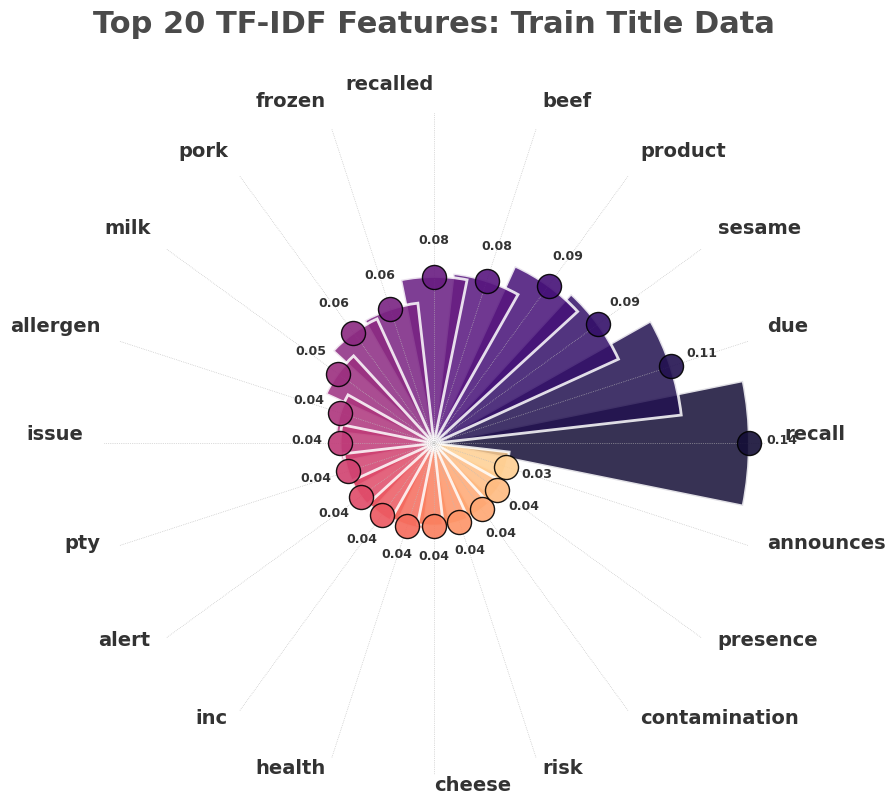

In [83]:
import matplotlib.pyplot as plt
import numpy as np

def create_sunburst_with_adjusted_labels(tfidf_df, title, colormap):
    # Calculate mean TF-IDF scores
    top_features = tfidf_df.mean().nlargest(20)  # Top 20 features based on mean values

    # Prepare data for sunburst plot
    features = top_features.index
    values = top_features.values
    colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    ax.set_facecolor("#ffffff")
    
    # Compute angle for each feature
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    values = np.concatenate((values, [values[0]]))

    # Add concentric segments (sunburst)
    for idx, (angle, value, color) in enumerate(zip(angles[:-1], values[:-1], colors)):
        ax.bar(x=angle, height=value, width=0.4, bottom=0, color=color, edgecolor='white', linewidth=2, alpha=0.85)
        
        # Draw a small circle for highlight effect at the top of each bar
        ax.scatter(angle, value, s=300, color=color, edgecolor='black', zorder=3, alpha=0.9)
        
        # Adjust label position to be closer to the bars dynamically
        label_position = value + 0.015  # Adjusting position for label to be closer
        ax.text(angle, label_position, f'{value:.2f}', ha='center', fontsize=9, fontweight='bold', color='#333333', zorder=4)

    # Set the labels for each feature
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=14, fontweight='bold', ha='center', color='#333333', rotation=45, va='bottom')
    
    # Move the labels dynamically based on angle for better alignment
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        label.set_rotation_mode('anchor')
        if 0 <= angle < np.pi / 2 or 3 * np.pi / 2 <= angle < 2 * np.pi:  # Right-side labels
            label.set_horizontalalignment('left')
        else:  # Left-side labels
            label.set_horizontalalignment('right')

    # Title with fancy styling
    ax.set_title(f'Top 20 TF-IDF Features: {title}', fontsize=22, fontweight='bold', color='#4a4a4a', pad=30)
    
    # Style adjustments for a more aesthetic look
    ax.grid(linewidth=0.5, linestyle=':', color='#bbbbbb')
    ax.spines['polar'].set_visible(False)

    # Remove radial tick labels for a cleaner look
    ax.set_yticks([])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()



# Train title TF-IDF
create_sunburst_with_adjusted_labels(title_tfidf_df, "Train Title Data", 'magma')




**Catboost for `Text` & `Titles`** 

In [ ]:
# Split data for `titles`
X_train_title, X_test_title, y_train_title_hazard_cat, y_test_title_hazard_cat = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['hazard-category'],  # Replace with the hazard category labels
    test_size=0.2,
    random_state=42
)

X_train_title, X_test_title, y_train_title_product_cat, y_test_title_product_cat = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['product-category'],  # Replace with the product category labels
    test_size=0.2,
    random_state=42
)

X_train_title, X_test_title, y_train_title_hazard, y_test_title_hazard = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['hazard'],  # Replace with the hazard labels
    test_size=0.2,
    random_state=42
)

X_train_title, X_test_title, y_train_title_product, y_test_title_product = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['product'],  # Replace with the product labels
    test_size=0.2,
    random_state=42
)

In [ ]:
# Split data for `texts`
X_train_text, X_test_text, y_train_text_hazard_cat, y_test_text_hazard_cat = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['hazard-category'],  # Replace with the hazard category labels
    test_size=0.2,
    random_state=42
)

X_train_text, X_test_text, y_train_title_product_cat, y_test_title_product_cat = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['product-category'],  # Replace with the product category labels
    test_size=0.2,
    random_state=42
)

X_train_text, X_test_text, y_train_text_hazard, y_test_text_hazard = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['hazard'],  # Replace with the hazard labels
    test_size=0.2,
    random_state=42
)

X_train_text, X_test_text, y_train_text_product, y_test_text_product = train_test_split(
    title_tfidf_df,  # TF-IDF features for titles
    train_data['product'],  # Replace with the product labels
    test_size=0.2,
    random_state=42
)

---

**Basic Model**
    *Training*

---

**Logistic Regression**

1. Logistic Regression is computationally lightweight and trains quickly even on large datasets.
It works well with high-dimensional sparse data like TF-IDF.
2. Logistic Regression is a strong baseline for text classification tasks.
It handles imbalanced class distributions reasonably well when paired with class weights.
3. The learned coefficients provide insight into the importance of features (e.g., TF-IDF terms).

In [18]:
# Step 1: Prepare training and validation labels

# Subtask 1
y_train_hazard_cat = train_data['hazard-category']  # Hazard category labels
y_train_product_cat = train_data['product-category']  # Product category labels

#Subtask 2
y_train_hazard = train_data['hazard']  # Hazard labels
y_train_product = train_data['product']  # Product labels

# Use TF-IDF features for both text and title
X_train_text = text_tfidf_df
X_train_title = title_tfidf_df
X_val_text = val_text_tfidf_df
X_val_title = val_title_tfidf_df



**Linear Regression for `Text` & `Titles`** 

The dataset is split into training and test subsets to evaluate model performance before making predictions on the validation dataset. The splits are applied for four target variables:
- hazard-category
- product-category
- hazard
- product

These variables correspond to the two main subtasks of the challenge.

In [19]:
# Split the training data into train and test subsets for `titles`
X_train_split_title, X_test_split_title, y_train_hazard_cat_split, y_test_hazard_cat_split = train_test_split(
    X_train_title, y_train_hazard_cat, test_size=0.2, random_state=42
)

X_train_split_title, X_test_split_title, y_train_product_cat_split, y_test_product_cat_split = train_test_split(
    X_train_title, y_train_product_cat, test_size=0.2, random_state=42
)

X_train_split_title, X_test_split_title, y_train_hazard_split, y_test_hazard_split = train_test_split(
    X_train_title, y_train_hazard, test_size=0.2, random_state=42
)

X_train_split_title, X_test_split_title, y_train_product_split, y_test_product_split = train_test_split(
    X_train_title, y_train_product, test_size=0.2, random_state=42
)


In [20]:
# Split the training data into train and test subsets for `text`
X_train_split_text, X_test_split_text, y_train_hazard_cat_split, y_test_hazard_cat_split = train_test_split(
    X_train_text, y_train_hazard_cat, test_size=0.2, random_state=42
)

X_train_split_text, X_test_split_text, y_train_product_cat_split, y_test_product_cat_split = train_test_split(
    X_train_text, y_train_product_cat, test_size=0.2, random_state=42
)

X_train_split_text, X_test_split_text, y_train_hazard_split, y_test_hazard_split = train_test_split(
    X_train_text, y_train_hazard, test_size=0.2, random_state=42
)

X_train_split_text, X_test_split_text, y_train_product_split, y_test_product_split = train_test_split(
    X_train_text, y_train_product, test_size=0.2, random_state=42
)


#### `Text`
#### **Subtask 1:**

**Evaluation of Model Performance**

We evaluate the model using **Macro F1 Score**, given the highly imbalanced nature of our dataset. The Macro F1 score ensures that each class contributes equally to the final score, making it more reliable for imbalanced classification.



Tune the `C` parameter (regularization strength) using a grid search to find the optimal balance between underfitting and overfitting.

In [21]:
# Define the parameter grid for Logistic Regression
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength
# Initialize Logistic Regression model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)


 ##### Hazard-Category

In [22]:
# Train Logistic Regression for hazard-category for text

# Perform Grid Search
grid_search_hazard_cat = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_hazard_cat.fit(X_train_split_text, y_train_hazard_cat_split)

# Predict on test subset
test_predictions_hazard_cat = grid_search_hazard_cat.predict(X_test_split_text)

# Compute scores
f1_hazard = f1_score(y_test_hazard_cat_split, test_predictions_hazard_cat, average='macro')
print(f"Macro F1-Score for Hazard-Category: {f1_hazard}")



c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Hazard-Category: 0.29722338886209515


In [23]:
import pandas as pd

# Generate classification report as a dictionary
report_dict = classification_report(y_test_hazard_cat_split, test_predictions_hazard_cat, zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Hazard-Category:")
report_df



Classification Report for Hazard-Category:


,precision,recall,f1-score,support
allergens,0.941718,0.814324,0.873400,377.000000
biological,0.850467,0.536873,0.658228,339.000000
chemical,0.289157,0.352941,0.317881,68.000000
food additives and flavourings,0.062500,0.400000,0.108108,5.000000
foreign bodies,0.438356,0.288288,0.347826,111.000000
fraud,0.223404,0.308824,0.259259,68.000000
migration,0.000000,0.000000,0.000000,1.000000
organoleptic aspects,0.078431,0.400000,0.131148,10.000000
other hazard,0.101124,0.333333,0.155172,27.000000
packaging defect,0.072727,0.363636,0.121212,11.000000


#### Product-Category

In [24]:
# Train Logistic Regression for Product-category for text

# Perform Grid Search
grid_search_product_cat = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_product_cat.fit(X_train_split_text, y_train_product_cat_split)

# Predict on test subset
test_predictions_product_cat = grid_search_product_cat.predict(X_test_split_text)

# Compute scores
f1_product = f1_score(y_test_product_cat_split, test_predictions_product_cat, average='macro')
print(f"Macro F1-Score for Product-Category: {f1_product}")

c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Product-Category: 0.13274107522706166


In [25]:
# Generate classification report as a dictionary
report_dict = classification_report(y_test_product_cat_split, test_predictions_product_cat,zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Product-Category:")
report_df



Classification Report for Product-Category:


,precision,recall,f1-score,support
alcoholic beverages,0.070423,0.714286,0.128205,7.000000
cereals and bakery products,0.360000,0.146341,0.208092,123.000000
"cocoa and cocoa preparations, coffee and tea",0.109375,0.142857,0.123894,49.000000
confectionery,0.055556,0.050000,0.052632,40.000000
"dietetic foods, food supplements, fortified foods",0.153846,0.250000,0.190476,24.000000
fats and oils,0.027027,0.250000,0.048780,4.000000
feed materials,0.000000,0.000000,0.000000,3.000000
food additives and flavourings,0.000000,0.000000,0.000000,0.000000
food contact materials,0.076923,1.000000,0.142857,1.000000
fruits and vegetables,0.313725,0.142857,0.196319,112.000000



#### **Subtask 2:**
 ##### Hazard

In [26]:
# Train Logistic Regression for hazard (vector)
grid_search_hazard = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_hazard.fit(X_train_split_text, y_train_hazard_split)

# Predict on test subset
test_predictions_hazard = grid_search_hazard.predict(X_test_split_text)

# Compute scores
f1_hazard_vector = f1_score(y_test_hazard_split, test_predictions_hazard, average='macro')
print(f"Macro F1-Score for Hazard (Vector): {f1_hazard_vector}")


c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Hazard (Vector): 0.11518479842115129


In [27]:
# Generate classification report as a dictionary
report_dict = classification_report(y_test_hazard_split, test_predictions_hazard,zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Hazard:")
report_df



Classification Report for Hazard:


,precision,recall,f1-score,support
Aflatoxin,0.000000,0.000000,0.000000,4.000000
abnormal smell,0.000000,0.000000,0.000000,0.000000
alcohol content,0.000000,0.000000,0.000000,1.000000
alkaloids,0.000000,0.000000,0.000000,2.000000
allergens,0.000000,0.000000,0.000000,4.000000
...,...,...,...,...
walnut,0.090909,0.200000,0.125000,5.000000
yeasts,0.000000,0.000000,0.000000,0.000000
accuracy,0.184857,0.184857,0.184857,0.184857
macro avg,0.122203,0.171318,0.115185,1017.000000


 ##### Product

In [28]:
# Train Logistic Regression for product (vector)
grid_search_product = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_product.fit(X_train_split_text, y_train_product_split)

# Predict on test subset
test_predictions_product = grid_search_product.predict(X_test_split_text)

# Compute scores
f1_product_vector = f1_score(y_test_product_split, test_predictions_product, average='macro')
print(f"Macro F1-Score for Product (Vector): {f1_product_vector}")


c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Product (Vector): 0.03441451624493347


In [29]:
# Generate classification report as a dictionary
report_dict = classification_report(y_test_product_split, test_predictions_product ,zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Product:")
report_df



Classification Report for Product:


,precision,recall,f1-score,support
Catfishes (freshwater),0.500000,0.400000,0.444444,5.000000
Dried pork meat,0.000000,0.000000,0.000000,0.000000
Fishes not identified,0.000000,0.000000,0.000000,6.000000
Not classified pork meat,0.000000,0.000000,0.000000,3.000000
Pangas catfishes (generic),0.000000,0.000000,0.000000,1.000000
...,...,...,...,...
wraps,0.000000,0.000000,0.000000,4.000000
yoghurt,0.000000,0.000000,0.000000,5.000000
accuracy,0.058014,0.058014,0.058014,0.058014
macro avg,0.037608,0.041676,0.034415,1017.000000



#### Compute the Combined Score:

In [30]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    f1_hazards = f1_score(hazards_true, hazards_pred, average='macro')
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )
    return (f1_hazards + f1_products) / 2.


Combined score 

In [31]:
# Compute the combined score for Subtask 1 `Text`
combined_score_text_st1 = compute_score(
    y_test_hazard_cat_split, y_test_product_cat_split,
    test_predictions_hazard_cat, test_predictions_product_cat
)

print(f"Combined Score for Hazard Category and Product Category Prediction: {combined_score_text_st1}")

# Compute the combined score for Subtask 2 `Text`
combined_score_text_st2 = compute_score(
    y_test_hazard_split, y_test_product_split,
    test_predictions_hazard, test_predictions_product
)

print(f"Combined Score for Hazard and Product Prediction: {combined_score_text_st2}")



Combined Score for Hazard Category and Product Category Prediction: 0.22363880803542158
Combined Score for Hazard and Product Prediction: 0.08404001825819468


The following chart is a Combined F1 Score Visualization comparing the performance of two subtasks (Subtask 1 and Subtask 2) for `Text`. Each bar represents the combined F1 score of the respective subtask.

* Subtask 1 has a combined F1 score of 0.22, as indicated by the taller teal bar on the left.
* Subtask 2 has a lower combined F1 score of 0.08, represented by the shorter orange bar on the right.
* The visualization uses rounded bars with gradient colors and highlighted callout labels for each score to emphasize the values. The contrast in bar height clearly indicates that Subtask 1 has significantly better performance than Subtask 2 in terms of the combined F1 metric.

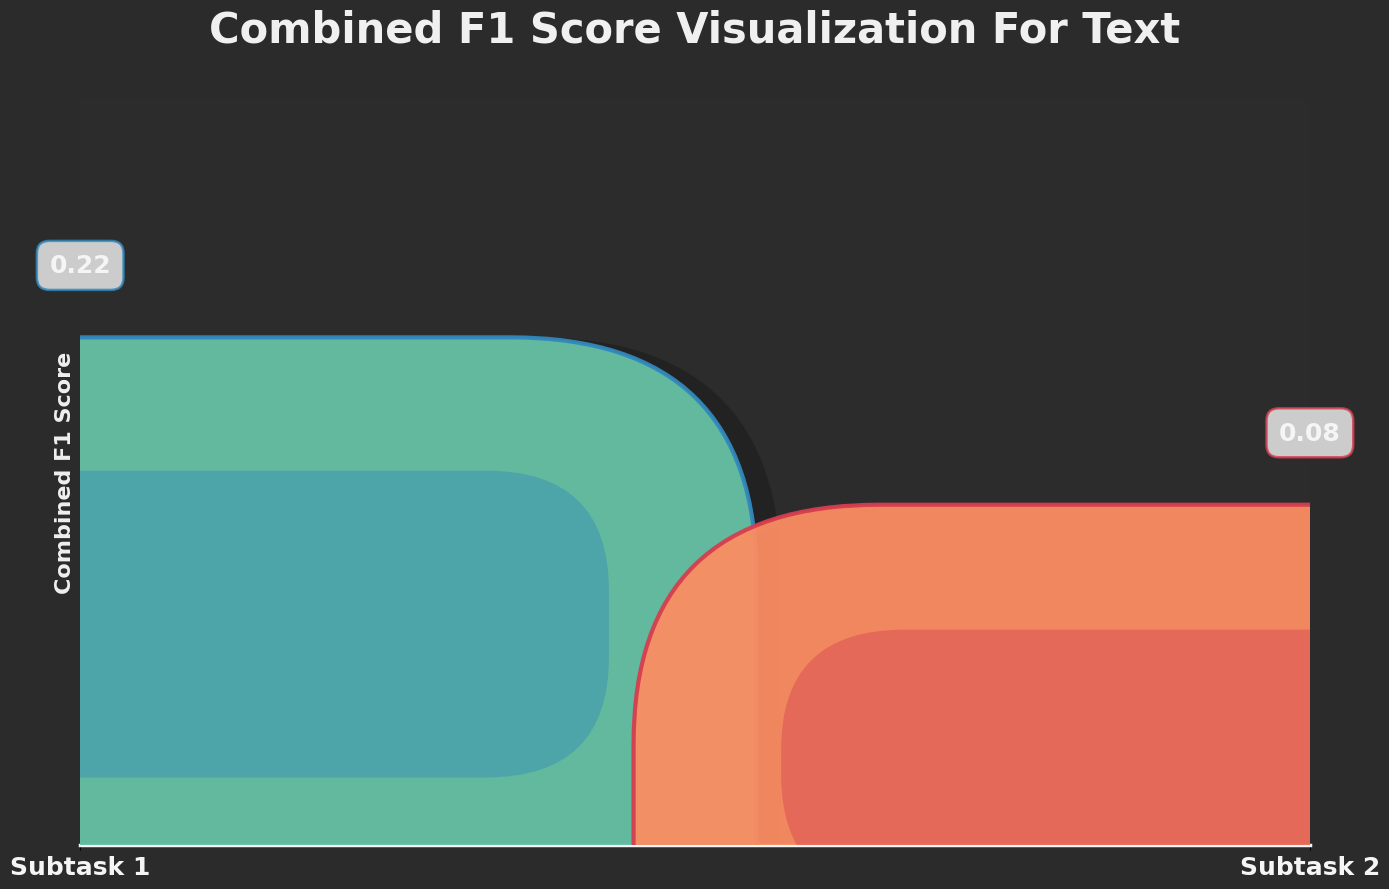

In [32]:
subtask_names = ['Subtask 1', 'Subtask 2']
combined_scores = [combined_score_text_st1, combined_score_text_st2]

# Color palette for a luxurious gradient and artistic effects
gradient_colors = [('#66c2a5', '#3288bd'), ('#fc8d62', '#d53e4f')]
highlight_color = '#f5f5f5'
background_color = '#2b2b2b'
title_color = '#f0f0f0'
shadow_color = '#1a1a1a'

# Plotting configuration
fig, ax = plt.subplots(figsize=(14, 9), facecolor=background_color)
ax.set_facecolor(background_color)

# Add multi-layered glow background to create a sense of depth
circle_1 = plt.Circle((0.5, 0.5), 1.5, color='#333333', alpha=0.1, transform=ax.transAxes, zorder=0)
circle_2 = plt.Circle((0.5, 0.5), 1.2, color='#444444', alpha=0.08, transform=ax.transAxes, zorder=0)
ax.add_patch(circle_1)
ax.add_patch(circle_2)

# Draw gradient bars with artistic design and subtle shadow effects
for idx, (score, colors) in enumerate(zip(combined_scores, gradient_colors)):
    # Use gradients for the bars
    bar = FancyBboxPatch(
        (idx - 0.35, 0),  # Coordinates
        0.7, score,  # Width and height
        boxstyle="round,pad=0.2",  # Rounded corners
        linewidth=3,
        edgecolor=colors[1],  # Outer gradient color
        facecolor=colors[0],  # Primary gradient color
        alpha=0.95,
        zorder=3
    )
    ax.add_patch(bar)

    # Add glow highlight on top of the bar to make it shine
    ax.add_patch(
        FancyBboxPatch(
            (idx - 0.33, score * 0.7),  # Coordinates to make it sit on the bar
            0.66, score * 0.25,  # Width and a fraction of height
            boxstyle="round,pad=0.1",  # Rounded corners
            linewidth=0,
            edgecolor=None,
            facecolor=colors[1],  # Lighter color to simulate glow
            alpha=0.4,
            zorder=4
        )
    )

    # Shadow effect behind bars for depth
    shadow = FancyBboxPatch(
        (idx - 0.35 + 0.02, -0.04),  # Slight offset for shadow
        0.7, score + 0.04,  # Width and height (slightly taller for shadow effect)
        boxstyle="round,pad=0.2",  # Rounded corners
        linewidth=0,
        facecolor=shadow_color,
        alpha=0.5,
        zorder=1  # Draw behind the bar
    )
    ax.add_patch(shadow)

# Add callout annotations above the bars with luxurious formatting
for idx, score in enumerate(combined_scores):
    ax.text(
        idx, score + 0.25,
        f'{score:.2f}',
        ha='center', va='bottom',
        fontsize=18, fontweight='bold',
        color=highlight_color,
        bbox=dict(boxstyle="round,pad=0.5", facecolor=highlight_color, edgecolor=gradient_colors[idx][1], linewidth=1.8, alpha=0.8),
        zorder=5  # Place text on top of everything else
    )

# Customizing the axes, title, and grid for an immersive effect
ax.set_xticks(np.arange(len(subtask_names)))
ax.set_xticklabels(subtask_names, fontsize=18, fontweight='bold', color=highlight_color)
ax.set_ylabel('Combined F1 Score', fontsize=16, fontweight='bold', color=title_color)
ax.set_ylim(0, max(combined_scores) + 0.4)
ax.set_yticks([])  # Hide y-ticks for an elegant look

# Add an enhanced title with rich typography
ax.set_title(
    'Combined F1 Score Visualization For Text',
    fontsize=30, fontweight='bold', color=title_color, pad=40, loc='center'
)

# Remove unnecessary spines and enhance the bottom spine
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_color(highlight_color)
ax.spines['bottom'].set_linewidth(2.5)

# Adding a soft, artistic dotted grid for readability
ax.yaxis.grid(True, linestyle=':', color='#888888', alpha=0.5)
ax.xaxis.grid(False)

# Adjust layout for balanced spacing and to maintain visual elegance
plt.tight_layout()
plt.show()


#### Predict on Validation Data


In [33]:
# Predict hazard-category on validation data text
val_predictions_hazard_cat = grid_search_hazard_cat.predict(X_val_text)

# Predict product-category on validation data text
val_predictions_product_cat = grid_search_product_cat.predict(X_val_text)

# Predict hazard (vector) on validation data text
val_predictions_hazard = grid_search_hazard.predict(X_val_text)

# Predict product (vector) on validation data text
val_predictions_product = grid_search_product.predict(X_val_text)


#### Save Predictions for Possible Submission

In [34]:
# Save predictions for Subtask 1 text
submission_lr_st1_text = pd.DataFrame({
    'hazard-category': val_predictions_hazard_cat,
    'product-category': val_predictions_product_cat
})


# Save predictions for Subtask 2 text
submission_lr_st2_text = pd.DataFrame({
    'hazard': val_predictions_hazard,
    'product': val_predictions_product
})




In [35]:
# submission_lr_st1_text.to_csv('C:\Users\magda\Desktop\pratical ds\Semeval2025-2\lr_submission_folder\submission_lr_st1_text.csv', index=False)
# submission_lr_st2_text.to_csv('C:\Users\magda\Desktop\pratical ds\Semeval2025-2\lr_submission_folder\submission_lr_st2_text.csv', index=False)

#### `Titles`
#### **Subtask 1:**
 ##### Hazard-Category

In [36]:
# Perform Grid Search for Hazard Category
grid_search_hazard_cat = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_hazard_cat.fit(X_train_split_title, y_train_hazard_cat_split)

# Predict on test subset
test_predictions_hazard_cat = grid_search_hazard_cat.predict(X_test_split_title)

# Compute scores
f1_hazard_cat = f1_score(y_test_hazard_cat_split, test_predictions_hazard_cat, average='macro')
print(f"Macro F1-Score for Hazard-Category: {f1_hazard_cat}")


c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Hazard-Category: 0.3313559027458465


In [37]:
# Generate classification report as a dictionary
report_dict = classification_report(y_test_hazard_cat_split, test_predictions_hazard_cat, zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Hazard-Category:")
report_df



Classification Report for Hazard-Category:


,precision,recall,f1-score,support
allergens,0.942623,0.610080,0.740741,377.000000
biological,0.872587,0.666667,0.755853,339.000000
chemical,0.326087,0.220588,0.263158,68.000000
food additives and flavourings,0.021739,0.200000,0.039216,5.000000
foreign bodies,0.638554,0.477477,0.546392,111.000000
fraud,0.196429,0.323529,0.244444,68.000000
migration,0.200000,1.000000,0.333333,1.000000
organoleptic aspects,0.055556,0.400000,0.097561,10.000000
other hazard,0.145833,0.259259,0.186667,27.000000
packaging defect,0.058824,0.545455,0.106195,11.000000


 ##### Product-Category

In [38]:
# For Product Category
grid_search_product_cat = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_product_cat.fit(X_train_split_title, y_train_product_cat_split)


# Predict on test subset
test_predictions_product_cat = grid_search_product_cat.predict(X_test_split_title)

# Compute scores
f1_product_cat = f1_score(y_test_product_cat_split, test_predictions_product_cat, average='macro')

print(f"Macro F1-Score for Product-Category: {f1_product_cat}")


c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Product-Category: 0.20503940937477436


In [39]:
# Generate classification report as a dictionary
report_dict = classification_report(y_test_product_cat_split, test_predictions_product_cat,zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Product-Category:")
report_df



Classification Report for Product-Category:


,precision,recall,f1-score,support
alcoholic beverages,0.035211,0.714286,0.067114,7.000000
cereals and bakery products,0.428571,0.024390,0.046154,123.000000
"cocoa and cocoa preparations, coffee and tea",0.588235,0.612245,0.600000,49.000000
confectionery,0.111111,0.050000,0.068966,40.000000
"dietetic foods, food supplements, fortified foods",0.088235,0.125000,0.103448,24.000000
fats and oils,0.035714,0.250000,0.062500,4.000000
feed materials,0.500000,0.333333,0.400000,3.000000
food additives and flavourings,0.000000,0.000000,0.000000,0.000000
food contact materials,0.040000,1.000000,0.076923,1.000000
fruits and vegetables,0.469388,0.205357,0.285714,112.000000


 ##### Hazard

In [40]:
# Perform Grid Search for Hazard (Vector)
grid_search_hazard_vector = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_hazard_vector.fit(X_train_split_title, y_train_hazard_split)

# Predict on test subset
test_predictions_hazard_vector = grid_search_hazard_vector.predict(X_test_split_title)

#Compute Scores
f1_hazard_vector = f1_score(y_test_hazard_split, test_predictions_hazard_vector, average='macro')
print(f"Macro F1-Score for Hazard (Vector): {f1_hazard_vector}")


c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Hazard (Vector): 0.10078086049613708


In [41]:

# Generate classification report as a dictionary
report_dict = classification_report(y_test_hazard_split, test_predictions_hazard_vector ,zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Hazard:")
report_df




Classification Report for Hazard:


,precision,recall,f1-score,support
Aflatoxin,0.200000,0.500000,0.285714,4.000000
alcohol content,0.000000,0.000000,0.000000,1.000000
alkaloids,0.000000,0.000000,0.000000,2.000000
allergens,0.000000,0.000000,0.000000,4.000000
almond,0.058824,0.071429,0.064516,14.000000
...,...,...,...,...
walnut,0.090909,0.200000,0.125000,5.000000
yeasts,0.000000,0.000000,0.000000,0.000000
accuracy,0.274336,0.274336,0.274336,0.274336
macro avg,0.110551,0.157147,0.100781,1017.000000


 ##### Product

In [42]:
# Perform Grid search for product (vector)
grid_search_product_vector = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_product_vector.fit(X_train_split_title, y_train_product_split)

# Predict on test subset
test_predictions_product_vector = grid_search_product_vector.predict(X_test_split_title)

# Compute scores
f1_product_vector = f1_score(y_test_product_split, test_predictions_product_vector, average='macro')
print(f"Macro F1-Score for Product (Vector): {f1_product_vector}")


c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-Score for Product (Vector): 0.04349221279045841


In [43]:
# Generate classification report as a dictionary
report_dict = classification_report(y_test_product_split, test_predictions_product_vector ,zero_division=0, output_dict=True)

# Convert to pandas DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Display the report 
print("\nClassification Report for Product:")
report_df




Classification Report for Product:


,precision,recall,f1-score,support
Catfishes (freshwater),0.000000,0.000000,0.000000,5.000000
Fishes not identified,0.000000,0.000000,0.000000,6.000000
Not classified pork meat,0.000000,0.000000,0.000000,3.000000
Pangas catfishes (generic),0.000000,0.000000,0.000000,1.000000
Precooked cooked pork meat products,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...
yoghurt,0.000000,0.000000,0.000000,5.000000
yogurt raisins,0.000000,0.000000,0.000000,0.000000
accuracy,0.092429,0.092429,0.092429,0.092429
macro avg,0.051086,0.045896,0.043492,1017.000000


#### Compute the combined score

In [44]:

# Compute the combined score for Subtask 1 `Title`
combined_score_title_st1 = compute_score(
    y_test_hazard_cat_split, y_test_product_cat_split,
    test_predictions_hazard_cat, test_predictions_product_cat
)

print(f"Combined Score for Hazard Category and Product Category Prediction: {combined_score_title_st1}")

# Compute the combined score for Subtask 2 `Title`
combined_score_title_st2 = compute_score(
    y_test_hazard_split, y_test_product_split,
    test_predictions_hazard_vector, test_predictions_product_vector
)

print(f"Combined Score for Hazard and Product Prediction: {combined_score_title_st2}")



Combined Score for Hazard Category and Product Category Prediction: 0.26558318887851456
Combined Score for Hazard and Product Prediction: 0.07910343265498919


#### Predict on validation data title

In [46]:
# Predict hazard-category on validation data title
val_predictions_hazard_cat = grid_search_hazard_cat.predict(X_val_title)

# Predict product-category on validation data title
val_predictions_product_cat = grid_search_product_cat.predict(X_val_title)

# Predict hazard (vector) on validation data title
val_predictions_hazard = grid_search_hazard_vector.predict(X_val_title)

# Predict product (vector) on validation data title
val_predictions_product = grid_search_product_vector.predict(X_val_title)


In [47]:
# Save predictions for Subtask 1 title
submission_lr_st1_title = pd.DataFrame({
    'hazard-category': val_predictions_hazard_cat,
    'product-category': val_predictions_product_cat
})


# Save predictions for Subtask 2 title
submission_lr_st2_title = pd.DataFrame({
    'hazard': val_predictions_hazard,
    'product': val_predictions_product
})




In [48]:
# submission_lr_st1_title.to_csv('C:\Users\magda\Desktop\pratical ds\Semeval2025-2\lr_submission_folder\submission_lr_st1_title.csv', index=False)
# submission_lr_st2_title.to_csv('C:\Users\magda\Desktop\pratical ds\Semeval2025-2\lr_submission_folder\submission_lr_st2_title.csv', index=False)